In [43]:
import sys, os, csv
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')
sys.path.insert(0, parent_directory)
from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import navpy
from gnssutils import EphemerisManager
import simplekml
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


In [44]:

def read_data(input_filepath):
    with open(input_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[0][0] == '#':
                if 'Fix' in row[0]:
                    android_fixes = [row[1:]]
                elif 'Raw' in row[0]:
                    measurements = [row[1:]]
            else:
                if row[0] == 'Fix':
                    android_fixes.append(row[1:])
                elif row[0] == 'Raw':
                    measurements.append(row[1:])
    return android_fixes, measurements

def process_data(android_fixes, measurements):
    android_fixes = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
    measurements = pd.DataFrame(measurements[1:], columns = measurements[0])

    measurements.loc[measurements['Svid'].str.len() == 1, 'Svid'] = '0' + measurements['Svid']
    measurements.loc[measurements['ConstellationType'] == '1', 'Constellation'] = 'G'
    measurements.loc[measurements['ConstellationType'] == '3', 'Constellation'] = 'R'
    measurements['SvName'] = measurements['Constellation'] + measurements['Svid']

    measurements = measurements.loc[measurements['Constellation'] == 'G']

    numeric_columns = ['Cn0DbHz', 'TimeNanos', 'FullBiasNanos', 'ReceivedSvTimeNanos', 'PseudorangeRateMetersPerSecond', 'ReceivedSvTimeUncertaintyNanos']
    for col in numeric_columns:
        measurements[col] = pd.to_numeric(measurements[col])

    measurements['BiasNanos'] = pd.to_numeric(measurements['BiasNanos'], errors='coerce').fillna(0)
    measurements['TimeOffsetNanos'] = pd.to_numeric(measurements['TimeOffsetNanos'], errors='coerce').fillna(0)

    measurements['GpsTimeNanos'] = measurements['TimeNanos'] - (measurements['FullBiasNanos'] - measurements['BiasNanos'])
    gpsepoch = datetime(1980, 1, 6, 0, 0, 0)
    measurements['UnixTime'] = pd.to_datetime(measurements['GpsTimeNanos'], utc = True, origin=gpsepoch)

    measurements['Epoch'] = 0
    measurements.loc[measurements['UnixTime'] - measurements['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
    measurements['Epoch'] = measurements['Epoch'].cumsum()

    return measurements

def calculate_measurements(measurements, ephemeris_data_directory):
    WEEKSEC = 604800
    LIGHTSPEED = 2.99792458e8

    measurements['tRxGnssNanos'] = measurements['TimeNanos'] + measurements['TimeOffsetNanos'] - (measurements['FullBiasNanos'].iloc[0] + measurements['BiasNanos'].iloc[0])
    measurements['GpsWeekNumber'] = np.floor(1e-9 * measurements['tRxGnssNanos'] / WEEKSEC)
    measurements['tRxSeconds'] = 1e-9 * measurements['tRxGnssNanos'] - WEEKSEC * measurements['GpsWeekNumber']
    measurements['tTxSeconds'] = 1e-9 * (measurements['ReceivedSvTimeNanos'] + measurements['TimeOffsetNanos'])
    measurements['prSeconds'] = measurements['tRxSeconds'] - measurements['tTxSeconds']
    measurements['PrM'] = LIGHTSPEED * measurements['prSeconds']
    measurements['PrSigmaM'] = LIGHTSPEED * 1e-9 * measurements['ReceivedSvTimeUncertaintyNanos']

    manager = EphemerisManager(ephemeris_data_directory)

    epoch = 0
    num_sats = 0
    while num_sats < 5:
        one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)].drop_duplicates(subset='SvName')
        timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime(warn=False)
        one_epoch.set_index('SvName', inplace=True)
        num_sats = len(one_epoch.index)
        epoch += 1

    sats = one_epoch.index.unique().tolist()
    ephemeris = manager.get_ephemeris(timestamp, sats)
    return measurements, one_epoch, ephemeris, manager

def calculate_satellite_position(ephemeris, transmit_time, one_epoch):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv'] = ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t_k'] = transmit_time - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = M_k + ephemeris['e']*np.sin(E_k)
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    sinE_k = np.sin(E_k)
    cosE_k = np.cos(E_k)
    delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    delT_oc = transmit_time - ephemeris['t_oc']
    sv_position['delT_sv'] = ephemeris['SVclockBias'] + ephemeris['SVclockDrift'] * delT_oc + ephemeris['SVclockDriftRate'] * delT_oc.pow(2)

    v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k, cosE_k - ephemeris['e'])
    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k
    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k
    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)
    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['Sat.X'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['Sat.Y'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['Sat.Z'] = y_k_prime*np.sin(i_k)

    pseudo_ranges = one_epoch['PrM']
    cn0 = one_epoch['Cn0DbHz']
    z_k_index = sv_position.columns.get_loc('Sat.Z') + 1
    sv_position.insert(z_k_index, 'Pseudo-Range', pseudo_ranges.values)
    sv_position.insert(z_k_index + 1, 'CN0', cn0.values)
    
    return sv_position

def export_to_csv(dataframe, file_path):
    dataframe.to_csv(file_path, index=True)

def least_squares(xs, measured_pseudorange, x0, b0):
    dx = 100*np.ones(3)
    b = b0
    G = np.ones((measured_pseudorange.size, 4))
    iterations = 0
    while np.linalg.norm(dx) > 1e-3:
        r = np.linalg.norm(xs - x0, axis=1)
        phat = r + b0
        deltaP = measured_pseudorange - phat
        G[:, 0:3] = -(xs - x0) / r[:, None]
        sol = np.linalg.inv(np.transpose(G) @ G) @ np.transpose(G) @ deltaP
        dx = sol[0:3]
        db = sol[3]
        x0 = x0 + dx
        b0 = b0 + db
    norm_dp = np.linalg.norm(deltaP)
    return x0, b0, norm_dp

def process_epochs(measurements, manager):
    ecef_list = []
    LIGHTSPEED = 2.99792458e8
    x = np.zeros(3)  # Initial guess for the receiver position
    b = 0  # Initial guess for the receiver clock bias
    for epoch in measurements['Epoch'].unique():
        one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)] 
        one_epoch = one_epoch.drop_duplicates(subset='SvName').set_index('SvName')
        if len(one_epoch.index) > 4:
            timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime(warn=False)
            sats = one_epoch.index.unique().tolist()
            ephemeris = manager.get_ephemeris(timestamp, sats)

            sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'], one_epoch)
            xs = sv_position[['Sat.X', 'Sat.Y', 'Sat.Z']].to_numpy()
            pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
            pr = pr.to_numpy()

            x, b, dp = least_squares(xs, pr, x, b)
            ecef_list.append(x)
    
    return np.stack(ecef_list, axis=0)

def create_kml(lla_array, output_file):
    kml = simplekml.Kml()
    for lat, lon, alt in lla_array:
        pnt = kml.newpoint()
        pnt.coords = [(lon, lat, alt)]
        pnt.altitudemode = simplekml.AltitudeMode.absolute
        pnt.extrude = 1
    kml.save(output_file)

def plot_ned(ned_array):
    ned_df = pd.DataFrame(ned_array, columns=['N', 'E', 'D'])
    plt.style.use('dark_background')
    plt.plot(ned_df['E'], ned_df['N'])
    plt.title('Position Offset From First Epoch')
    plt.xlabel("East (m)")
    plt.ylabel("North (m)")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [45]:

def main(input_filepath):
    
    android_fixes, measurements = read_data(input_filepath)
    measurements = process_data(android_fixes, measurements)
    measurements, one_epoch, ephemeris, manager = calculate_measurements(measurements, ephemeris_data_directory)
    
    sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'], one_epoch)
    export_to_csv(sv_position, 'satellite_position.csv')

    ecef_array = process_epochs(measurements, manager)
    lla_array = np.stack(navpy.ecef2lla(ecef_array), axis=1)
    ref_lla = lla_array[0, :]
    ned_array = navpy.ecef2ned(ecef_array, ref_lla[0], ref_lla[1], ref_lla[2])
    
    plot_ned(ned_array)
    create_kml(lla_array, 'gps_positions.kml')


D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_list, ignore_index=True)
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'co

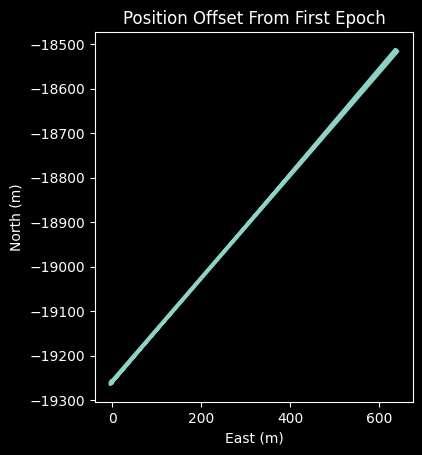

In [46]:
#Run :
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')
input_filepath = os.path.join('gnss_log_2024_04_13_19_51_17.txt')
main(input_filepath)

In [47]:
#Tests:

D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_list, ignore_index=True)
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'co

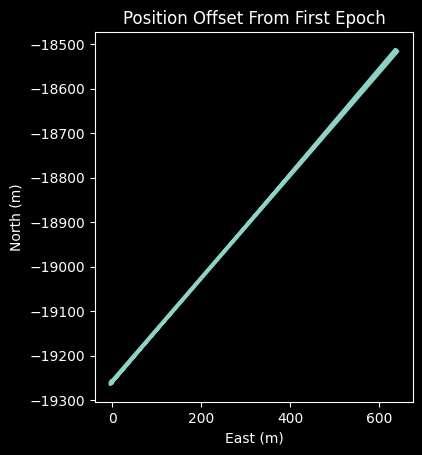

D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_list, ignore_index=True)
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'co

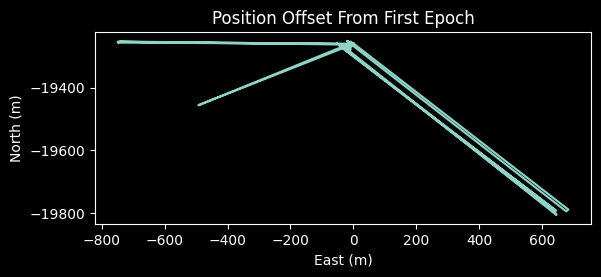

D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_list, ignore_index=True)
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'columns')
D:\jupyterProjects\tempRepo\gnss-analysis\gnssutils\ephemeris_manager.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  'sv').last().drop('index', 'co

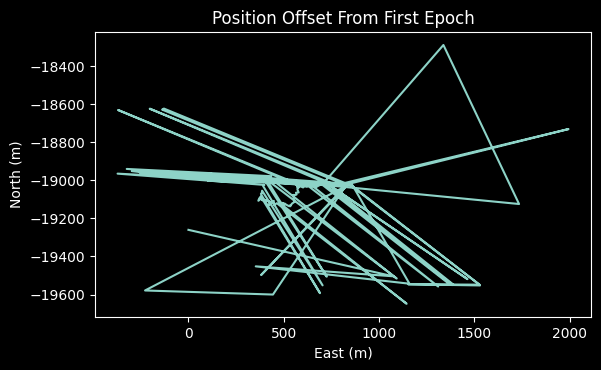

In [48]:
#Test 1:
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')
input_filepath = os.path.join('gnss_log_2024_04_13_19_51_17.txt')
main(input_filepath)

#Test 2:
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')
input_filepath = os.path.join('gnss_log_2024_04_13_19_52_00.txt')
main(input_filepath)

#Test 3:
parent_directory = os.path.split(os.getcwd())[0]
ephemeris_data_directory = os.path.join(parent_directory, 'data')
input_filepath = os.path.join('gnss_log_2024_04_13_19_53_33.txt')
main(input_filepath)